First let's see some classification hypothesis evaluation functions treating equally the different classes

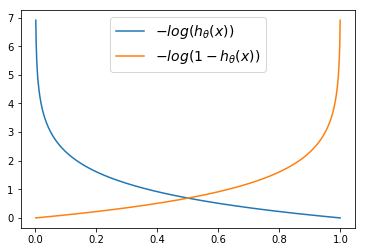

In [2]:
import numpy as np
import matplotlib.pyplot as plt

step = 0.001
x_axis = np.arange(step,1,step)
y1_axis = -np.log(x_axis)
y2_axis = -np.log(1-x_axis)
plt.plot(x_axis,y1_axis, label = '$-log(h_{\\theta}(x))$')
plt.plot(x_axis,y2_axis, label = '$-log(1-h_{\\theta}(x))$')
plt.legend(loc='upper center', prop={'size': 14})
plt.show()

### Now let's do cost-based evaluation. 

We must install the latest version of the costcla library using the following command at the command line:
pip install git+git://github.com/albahnsen/CostSensitiveClassification.git

In [2]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from costcla.metrics import cost_loss

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=0)

# 0 is malignant, 1 is benign
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 4)
fn = np.full((y_test.shape[0],1), 1)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

print("random forest")
clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides


print("linear SVM")
clf = SVC(kernel='linear', probability=True, C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

/home/theo/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/theo/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


random forest
             precision    recall  f1-score   support

  malignant       0.94      0.95      0.94        63
     benign       0.97      0.96      0.97       108

avg / total       0.96      0.96      0.96       171

16

[[ 60   4]
 [  3 104]]
linear SVM
             precision    recall  f1-score   support

  malignant       0.92      0.97      0.95        63
     benign       0.98      0.95      0.97       108

avg / total       0.96      0.96      0.96       171

13

[[ 61   5]
 [  2 103]]


### Minizing the expected cost

In [16]:
pip install scikit-learn==0.19

    100% |████████████████████████████████| 12.4MB 89kB/s 
Note: you may need to restart the kernel to use updated packages.


In [4]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from costcla.models import BayesMinimumRiskClassifier

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=0)
# 0 is malignant, 1 is benign
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 4)
fn = np.full((y_test.shape[0],1), 1)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

print("no cost minimization")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)
print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides


print("no calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("costcla calibration on training set")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
model = clf.fit(X_train, y_train)
prob_train = model.predict_proba(X_train)
bmr = BayesMinimumRiskClassifier(calibration=True)
bmr.fit(y_train, prob_train) 
prob_test = model.predict_proba(X_test)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("\nsigmoid calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
cc = CalibratedClassifierCV(clf, method="sigmoid", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("\nisotonic calibration")
clf = RandomForestClassifier(random_state=0, n_estimators=100)
cc = CalibratedClassifierCV(clf, method="isotonic", cv=3)
model = cc.fit(X_train, y_train)
prob_test = model.predict_proba(X_test)
bmr = BayesMinimumRiskClassifier(calibration=False)
pred_test = bmr.predict(prob_test, cost_matrix)
print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

no cost minimization
             precision    recall  f1-score   support

  malignant       0.94      0.95      0.94        63
     benign       0.97      0.96      0.97       108

avg / total       0.96      0.96      0.96       171

16

[[ 60   4]
 [  3 104]]
no calibration
             precision    recall  f1-score   support

  malignant       0.79      1.00      0.88        63
     benign       1.00      0.84      0.91       108

avg / total       0.92      0.90      0.90       171

17

[[63 17]
 [ 0 91]]
costcla calibration on training set
             precision    recall  f1-score   support

  malignant       0.89      0.98      0.93        63
     benign       0.99      0.93      0.96       108

avg / total       0.95      0.95      0.95       171

12

[[ 62   8]
 [  1 100]]

sigmoid calibration
             precision    recall  f1-score   support

  malignant       0.85      1.00      0.92        63
     benign       1.00      0.90      0.95       108

avg / total       0.95  

Rebalancing
pip install -U git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [3]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from costcla.metrics import cost_loss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=0)

# 0 is malignant, 1 is benign
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 4)
fn = np.full((y_test.shape[0],1), 1)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))


clf = RandomForestClassifier(n_estimators=100, random_state=0)
print("without sampling")
print(Counter(y_train))
#0: 149, 1: 249

model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

print("with undersampling")
sampler = RandomUnderSampler(sampling_strategy={0: 149, 1: 37}, random_state=1)
X_rs, y_rs = sampler.fit_sample(X_train, y_train)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

print("with oversampling")
sampler = RandomOverSampler(sampling_strategy={0: 1000, 1: 249}, random_state=1)
X_rs, y_rs = sampler.fit_sample(X_train, y_train)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides

print("with combination")
sampler = RandomUnderSampler(sampling_strategy={0: 149, 1: 100}, random_state=1)
X_rs, y_rs = sampler.fit_sample(X_train, y_train)
sampler = RandomOverSampler(sampling_strategy={0: 400, 1: 100}, random_state=1)
X_rs, y_rs = sampler.fit_sample(X_rs, y_rs)
print(Counter(y_rs))

model = clf.fit(X_rs, y_rs)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=data.target_names))
loss = cost_loss(y_test, y_pred, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, y_pred).T) # transpose to align with slides


without sampling
Counter({1: 249, 0: 149})
             precision    recall  f1-score   support

  malignant       0.94      0.95      0.94        63
     benign       0.97      0.96      0.97       108

avg / total       0.96      0.96      0.96       171

16

[[ 60   4]
 [  3 104]]
with undersampling
Counter({0: 149, 1: 37})
             precision    recall  f1-score   support

  malignant       0.77      1.00      0.87        63
     benign       1.00      0.82      0.90       108

avg / total       0.91      0.89      0.89       171

19

[[63 19]
 [ 0 89]]
with oversampling
Counter({0: 1000, 1: 249})


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (1000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 249)
  n_samples_majority))


             precision    recall  f1-score   support

  malignant       0.92      0.95      0.94        63
     benign       0.97      0.95      0.96       108

avg / total       0.95      0.95      0.95       171

17

[[ 60   5]
 [  3 103]]
with combination
Counter({0: 400, 1: 100})


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (400) in class 0 will be larger than the number of samples in the majority class (class #0 -> 149)
  n_samples_majority))


             precision    recall  f1-score   support

  malignant       0.84      1.00      0.91        63
     benign       1.00      0.89      0.94       108

avg / total       0.94      0.93      0.93       171

12

[[63 12]
 [ 0 96]]


Using sample weights

In [6]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from costcla.metrics import cost_loss

data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.3, random_state=0)

# 0 is malignant, 1 is benign
#fp, fn, tp, tn
fp = np.full((y_test.shape[0],1), 4)
fn = np.full((y_test.shape[0],1), 1)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

print("without weights")
clf = RandomForestClassifier(n_estimators=10, random_state=0)
#clf = SVC(kernel='linear', probability=False, C=1)
#clf = DecisionTreeClassifier()
model = clf.fit(X_train, y_train)
pred_test = model.predict(X_test)

print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

print("\nwith weights")
# now create the sample weights according to y
weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1;
weights[np.where(y_train == 0)] = 4;
#print(data.DESCR)

model = clf.fit(X_train, y_train, weights)
pred_test = clf.predict(X_test)

print(classification_report(y_test, pred_test, target_names=data.target_names))
loss = cost_loss(y_test, pred_test, cost_matrix)
print("%d\n" %loss)
print(confusion_matrix(y_test, pred_test).T) # transpose to align with slides

without weights
              precision    recall  f1-score   support

   malignant       0.91      0.94      0.92        63
      benign       0.96      0.94      0.95       108

   micro avg       0.94      0.94      0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

22

[[ 59   6]
 [  4 102]]

with weights
              precision    recall  f1-score   support

   malignant       0.95      0.94      0.94        63
      benign       0.96      0.97      0.97       108

   micro avg       0.96      0.96      0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

19

[[ 59   3]
 [  4 105]]


Another probability calibration example

In [12]:
import time
from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import AdaBoostClassifier

#data = datasets.load_breast_cancer()
#data = datasets.load_iris()
#data = datasets.load_digits()
#data = fetch_mldata('datasets-UCI credit-g')
#data = fetch_mldata('MNIST original')

classifiers = []

ada = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=100, random_state=1)
classifiers.append([ada, "AdaBoost-ed tree"])

ada_cal = CalibratedClassifierCV(AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=100, random_state=1), cv=2, method='isotonic')
classifiers.append([ada_cal, "calibrated AdaBoost-ed tree (isotonic)"])

ada_cal2 = CalibratedClassifierCV(AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(),n_estimators=100, random_state=1), cv=2, method='sigmoid')
classifiers.append([ada_cal2, "calibrated AdaBoost-ed tree (sigmoid)"])

neighbors = 10;
knn = KNeighborsClassifier(n_neighbors=neighbors)
classifiers.append([knn, "kNN"])

knn_cal = CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=neighbors), cv=2, method='isotonic')
classifiers.append([knn_cal, "calibrated kNN (isotonic)"])

knn_cal2 = CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=neighbors), cv=2, method='sigmoid')
classifiers.append([knn_cal2, "calibrated kNN (sigmoid)"])


for classifier, label in classifiers:
    start = time.time()
    scores = cross_val_score(classifier, data.data, data.target, cv=10, scoring="neg_log_loss")
    stop = time.time()
    print("%20s log_loss: %0.2f (+/- %0.2f), time:%.4f" % (label, scores.mean(), scores.std() * 2, stop - start))

print()

for classifier, label in classifiers:
    start = time.time()
    scores = cross_val_score(classifier, data.data, data.target, cv=10, scoring="neg_mean_squared_error")
    stop = time.time()
    print("%20s squared error: %0.2f (+/- %0.2f), time:%.4f" % (label, scores.mean(), scores.std() * 2, stop - start))

    AdaBoost-ed tree log_loss: -2.84 (+/- 2.39), time:0.1369
calibrated AdaBoost-ed tree (isotonic) log_loss: -0.22 (+/- 0.11), time:0.2115
calibrated AdaBoost-ed tree (sigmoid) log_loss: -0.23 (+/- 0.11), time:0.2658
                 kNN log_loss: -0.56 (+/- 0.89), time:0.0517
calibrated kNN (isotonic) log_loss: -0.23 (+/- 0.36), time:0.1819
calibrated kNN (sigmoid) log_loss: -0.20 (+/- 0.11), time:0.2366

    AdaBoost-ed tree squared error: -0.08 (+/- 0.07), time:0.1338
calibrated AdaBoost-ed tree (isotonic) squared error: -0.07 (+/- 0.07), time:0.1939
calibrated AdaBoost-ed tree (sigmoid) squared error: -0.07 (+/- 0.07), time:0.2536
                 kNN squared error: -0.07 (+/- 0.07), time:0.0596
calibrated kNN (isotonic) squared error: -0.06 (+/- 0.06), time:0.1869
calibrated kNN (sigmoid) squared error: -0.07 (+/- 0.06), time:0.2454
